# Tutorial: AIFairness 360

- 07/19/24 -  Practicing AI Fairness 360
> Following along with:
>- Video: https://community.ibm.com/community/user/ai-datascience/viewdocument/removing-unfair-bias-in-machine-lea
>- Example Notebook: https://github.com/Trusted-AI/AIF360/blob/main/examples/tutorial_medical_expenditure.ipynb

### Use case

In order to demonstrate how AIF 360 can be used to detect and mitigate bias in classfier models, we adopt the following use case:

- a data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions be not predicated on factors such as race of the patient.

- developer takes the model AND performance characteristics / specs of the model (e.g. accuracy, fairness tests, etc. basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.

- the app is put into production and starts scoring people and making recommendations.

- explanations are generated for each recommendation

- both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.

- nurse feedback as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness is communicated to AI Ops specialist and LOB user periodically.

- when significant drift in model specs relative to the model factsheet is observed, the model is sent back for retraining.

# The Data

> Source https://github.com/Trusted-AI/AIF360/blob/main/examples/tutorial_medical_expenditure.ipynb#2.%20Data%20Used


The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

For this demonstration, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

***For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.***

Along with race as the sensitive feature, other features used for modeling include demographics (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).

To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits; OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits; IPNGTD15(16), the number of inpatient nights, and + HHTOTD16, the number of home health visits.

>The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.

We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data. (Use case steps 1-2.) It is then put into practice and used to score people to identify potential candidates for care management (Use case steps 3-5). Initial deployment is simulated to 2015 Panel 20 deployment data. To show change in performance and/or fairness over time, (use case steps 6-7), the 2016 Panel 21 deployment data is used. Finally, if drift is observed, the 2015 train/validation data is used to learn a new model and evaluated again on the 2016 deployment data



## Training Models

In [3]:
# !pip install lime

In [4]:
import sys
sys.path.insert(0, '../')

# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

In [5]:

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline



In [6]:
## Metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer


/opt/homebrew/Caskroom/miniforge/base/envs/fair-env/lib/python3.12/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [7]:
# !pip install lime

In [8]:
# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

## Lime explainer
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer
# from aif360.explainers.lime import Lime

np.random.seed(1)

## 3.1. Load data & create train/val/test splits for training model


### Tutorial's Way

To install the data (after installing R with homebrew):
```bash
cd "/opt/homebrew/Caskroom/miniforge/base/envs/fair-env/lib/python3.12/site-packages/aif360/data/raw/meps/"
Rscript generate_data.R
```

In [9]:
# Download the dataset and split into train and test and validation
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)
dataset_orig_panel19_train

               instance weights features                                    \
                                         protected attribute                 
                                     AGE                RACE  PCS42  MCS42   
instance names                                                               
6274                9584.405538     56.0                 0.0  24.59  38.23   
4403               13501.448564     19.0                 1.0  -1.00  -1.00   
8660                   0.000000     73.0                 1.0  -1.00  -1.00   
1220               45482.792820     73.0                 1.0  23.64  63.41   
12020               4639.875613      2.0                 0.0  -1.00  -1.00   
...                         ...      ...                 ...    ...    ...   
13556               8527.049685      7.0                 1.0  -1.00  -1.00   
16232               6809.283500     18.0                 0.0  52.40  62.66   
279                 3750.437997     19.0                 0.0  56

In [10]:
feature_names = dataset_orig_panel19_train.feature_names
print(feature_names)

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

In [11]:
# Slice the dataset to to identify the protected attribute
sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]
sens_attr

'RACE'

In [12]:
# Define the unprivileged and privileged groups
unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]

unprivileged_groups

[{'RACE': 0.0}]

In [13]:
# Define the unprivileged and privileged groups
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]
privileged_groups

[{'RACE': 1.0}]

### my way

In [14]:
data = MEPSDataset19()
data


               instance weights features                                    \
                                         protected attribute                 
                                     AGE                RACE  PCS42  MCS42   
instance names                                                               
0                  21854.981705     53.0                 1.0  25.93  58.47   
1                  18169.604822     56.0                 1.0  20.42  26.57   
3                  17191.832515     23.0                 1.0  53.12  50.33   
4                  20261.485463      3.0                 1.0  -1.00  -1.00   
5                      0.000000     27.0                 0.0  -1.00  -1.00   
...                         ...      ...                 ...    ...    ...   
16573               4111.315754     25.0                 0.0  56.71  62.39   
16574               5415.228173     25.0                 0.0  56.71  62.39   
16575               3896.116219      2.0                 1.0  -1

In [15]:
# Separate the data as a dataframe and a data dictionary
df,data_dict = data.convert_to_dataframe()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 15830 entries, 0 to 16577
Columns: 139 entries, AGE to UTILIZATION
dtypes: float64(139)
memory usage: 16.9+ MB


,AGE,RACE,PCS42,MCS42,K6SUM42,REGION=1,REGION=2,REGION=3,REGION=4,SEX=1,...,EMPST=4,POVCAT=1,POVCAT=2,POVCAT=3,POVCAT=4,POVCAT=5,INSCOV=1,INSCOV=2,INSCOV=3,UTILIZATION
0,53.0,1.0,25.93,58.47,3.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,56.0,1.0,20.42,26.57,17.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,23.0,1.0,53.12,50.33,7.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.0,1.0,-1.00,-1.00,-1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,27.0,0.0,-1.00,-1.00,-1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
# Binary target label
df['UTILIZATION'].value_counts()

UTILIZATION
0.0    13112
1.0     2718
Name: count, dtype: int64

In [17]:
## Train test val split
train, test_val = train_test_split(df, test_size=0.5, random_state=1, stratify=df['RACE'])
test, val = train_test_split(test_val, test_size=0.4, random_state=1, stratify=test_val['RACE'])
train.shape, test.shape, val.shape


((7915, 139), (4749, 139), (3166, 139))

In [18]:
# Exploring the data dictionary
data_dict.keys()

dict_keys(['feature_names', 'label_names', 'protected_attribute_names', 'instance_names', 'instance_weights', 'privileged_protected_attributes', 'unprivileged_protected_attributes'])

In [19]:
data_dict['label_names']

['UTILIZATION']

In [20]:
data_dict['protected_attribute_names']

['RACE']

In [21]:
data_dict['privileged_protected_attributes']

[array([1.])]

In [22]:
data_dict['unprivileged_protected_attributes']

[array([0.])]

In [ ]:
# Define the unprivileged and privileged groups
privileged_groups =[ ]
unprivileged_groups = [ ]

for sens_attr in data_dict['protected_attribute_names']:
    
    temp = data_dict['privileged_protected_attributes']
    privileged_groups.append({sens_attr: temp[0][0]})
    
    temp = data_dict['unprivileged_protected_attributes']
    unprivileged_groups.append({sens_attr: temp[0][0]})
privileged_groups, unprivileged_groups

([{'RACE': 1.0}], [{'RACE': 0.0}])

### Fairness Metrics for Original Data

In [ ]:
try:
    metric_orig_panel19_train = BinaryLabelDatasetMetric(
            train,
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups)
    explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

    print(explainer_orig_panel19_train.disparate_impact())
except Exception as e:
    display(e)

TypeError("'dataset' should be a BinaryLabelDataset or a MulticlassLabelDataset")

> Metrics are only desgned to work with proprieatary data sets

In [ ]:
from aif360.datasets import StandardDataset, BinaryLabelDataset

# Specify the column names for labels and protected attributes
label_name = 'UTILIZATION' # Replace with your actual label column name
protected_attribute_names = data_dict['protected_attribute_names'] # Replace with your actual protected attribute column names

# print(protected_attribute_names)
# Create the AIF360 dataset
dataset = StandardDataset(
    train,
    label_name=label_name,
    protected_attribute_names=protected_attribute_names,
    favorable_classes=[1],  # Specify the favorable class (adjust as needed)
    privileged_classes=data_dict['privileged_protected_attributes']# Specify the privileged class for each protected attribute (adjust as needed)
)

dataset

               instance weights features                                    \
                                         protected attribute                 
                                     AGE                RACE  PCS42  MCS42   
instance names                                                               
9849                        1.0     57.0                 1.0  38.71  34.06   
15176                       1.0     39.0                 0.0  -9.00  -9.00   
10225                       1.0     39.0                 1.0  -1.00  -1.00   
4926                        1.0     43.0                 0.0  59.99  46.10   
10855                       1.0     25.0                 0.0  61.52  42.10   
...                         ...      ...                 ...    ...    ...   
15230                       1.0     10.0                 0.0  -1.00  -1.00   
12459                       1.0      2.0                 0.0  -1.00  -1.00   
7100                        1.0     62.0                 1.0  39

In [ ]:
# Assuming 'label' is your target column and 'gender' is your protected attribute
def make_binary_dataset(train, data_dict):
    binary_dataset_train = BinaryLabelDataset(
        df=train,
        label_names=["UTILIZATION"], # Name of the label column
        protected_attribute_names = data_dict['protected_attribute_names'], # Replace with your actual protected attribute column names
        favorable_label=1,
        unfavorable_label=0
    )
    return binary_dataset_train

binary_dataset_train = make_binary_dataset(train, data_dict)
binary_dataset_test = make_binary_dataset(test, data_dict)
binary_dataset_val = make_binary_dataset(val, data_dict)

In [ ]:
data_dict['unprivileged_protected_attributes']

[array([0.])]

In [ ]:

metric_orig_panel19_train = BinaryLabelDatasetMetric(
        binary_dataset_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact())


Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.5012581633592118


> Since the value for disparate impact is not 1, there is bias in the training dataset.

## To Do:
- Clarify which group should be privileged vs. unpriviledged ***based on business case.***

## Modeling

### LogReg

In [ ]:
import seaborn as sns

<Axes: ylabel='Count'>

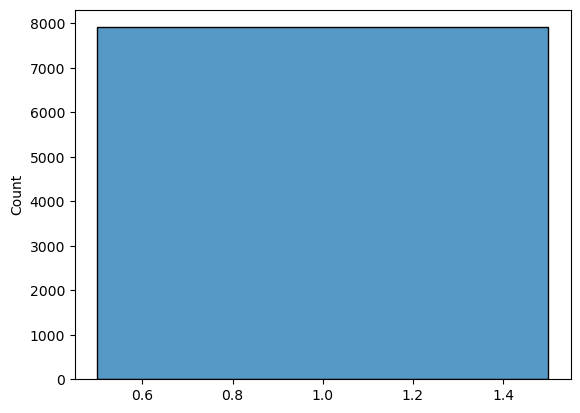

In [ ]:
sns.histplot(binary_dataset_train.instance_weights)

<Axes: ylabel='Count'>

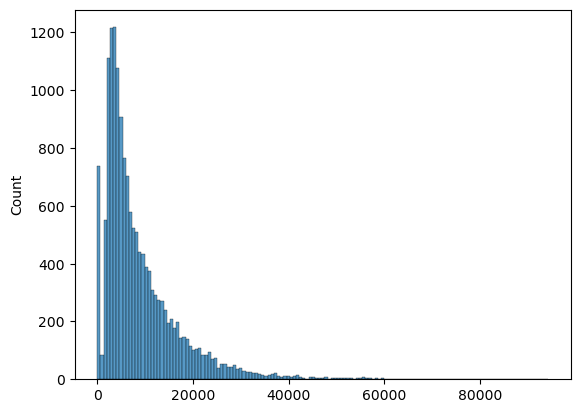

In [ ]:
# Compare to initital dataset weights
sns.histplot(data.instance_weights)

#### TO DO: Find out how to calculate instance_weights to include

In [ ]:
scaler = StandardScaler()

model_params = {'solver': 'liblinear', 'random_state': 1, 'max_iter': 1000}
pipe = make_pipeline(scaler, LogisticRegression(**model_params))

fit_params = {'logisticregression__sample_weight': binary_dataset_train.instance_weights} # Note that right now all are ==1
lr_orig = pipe.fit(binary_dataset_train.features, binary_dataset_train.labels.ravel(), **fit_params)

In [ ]:
!pip install dojo_ds
import dojo_ds as ds

help(ds.evaluate.evaluate_classification) #(lr_orig, binary_dataset_test, privileged_groups, unprivileged_groups)

  Using cached dojo_ds-1.1.11-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached dojo_ds-1.1.11-py2.py3-none-any.whl (60 kB)
Help on function evaluate_classification in module dojo_ds.evaluate:

evaluate_classification(model, X_train=None, y_train=None, X_test=None, y_test=None, figsize=(6, 4), normalize='true', output_dict=False, cmap_train='Blues', cmap_test='Reds', colorbar=False, values_format='.2f', target_names=None, return_fig=False)
    Evalutes an sklearn-compatible classification model on training and test data.
    For each data split, return the classification report and confusion matrix display.

    Args:
        model (sklearn estimator): Classification model to evaluate.
        X_train (Frame/Array, optional): Training data. Defaults to None.
        y_train (Series/Array, optional): Training labels. Defaults to None.
        X_test (Frame/Array, optional): Test data. Defaults to None.
        y_test (Series/Array, optional): Test labels. Defaults to None.
        fig

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      6542
         1.0       0.69      0.42      0.52      1373

    accuracy                           0.87      7915
   macro avg       0.79      0.69      0.72      7915
weighted avg       0.85      0.87      0.85      7915



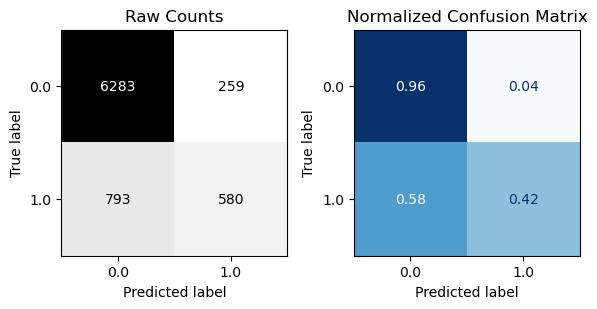


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      3960
         1.0       0.67      0.37      0.48       789

    accuracy                           0.86      4749
   macro avg       0.78      0.67      0.70      4749
weighted avg       0.85      0.86      0.85      4749



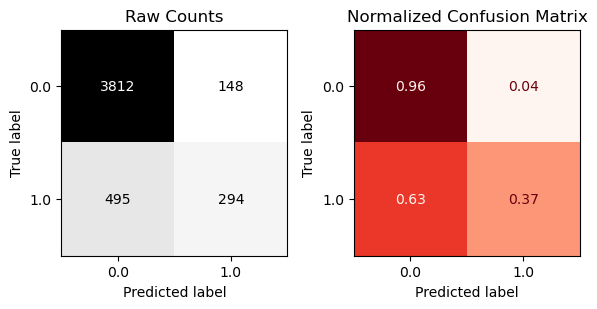

In [ ]:
ds.evaluate.evaluate_classification(lr_orig, binary_dataset_train.features, binary_dataset_train.labels.ravel(),
                                    binary_dataset_test.features, binary_dataset_test.labels.ravel())

#### [jmi] Using simple techniques to reveal bias

In [ ]:
train.groupby('RACE')['UTILIZATION'].value_counts(normalize=True).to_frame()#.unstack().plot(kind='bar')#, stacked=True)

proportion
RACE UTILIZATION            
0.0  0.0            0.872027
     1.0            0.127973
1.0  0.0            0.744696
     1.0            0.255304

- When RACE is 0, 12% are target=1.
- When RACE is 1, 26% are target=1.

In [ ]:
y_hat_train = pipe.predict(binary_dataset_train.features)
y_hat_train

array([0., 1., 0., ..., 0., 0., 0.])

In [ ]:
train['Model Prediction'] = y_hat_train
train.groupby("RACE")['Model Prediction'].value_counts(normalize=True).to_frame()#unstack().plot(kind='bar', stacked=True)

proportion
RACE Model Prediction            
0.0  0.0                 0.936112
     1.0                 0.063888
1.0  0.0                 0.818246
     1.0                 0.181754

- When RACE is 0, model predicts 1 for 6%  of the observations
- When RACE is 1, model predicts 1 for 18% of the observations.